# Installs & Imports

In [1]:
import math
from itertools import product
from functools import lru_cache
from joblib import Parallel, delayed
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.discrete.discrete_model as dm
from patsy import dmatrices
import statsmodels.graphics.tsaplots as tsa
from matplotlib import pyplot as plt
from scipy.stats import poisson, binom, nbinom, norm
from statsmodels.base.model import GenericLikelihoodModel
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# Load the Data

In [2]:
# Load the STRIKES dataset from the 'Ecdat' package
strikes_dataset = sm.datasets.get_rdataset(dataname='StrikeNb', package='Ecdat')
strikes_data = strikes_dataset.data.copy()

# Generate actual date information
strikes_data['date'] = pd.date_range(start='1968-01-01', periods=len(strikes_data), freq='MS')

In [3]:
# Display the first few rows of the dataset
print("=== Dataset Head ===")
display(strikes_data.head())

print("\n=== Dataset Tail ===")
display(strikes_data.tail())

=== Dataset Head ===


,strikes,output,time,date
0,5,0.01517,1,1968-01-01
1,4,0.00997,2,1968-02-01
2,6,0.01170,3,1968-03-01
3,16,0.00473,4,1968-04-01
4,5,0.01277,5,1968-05-01



=== Dataset Tail ===


,strikes,output,time,date
103,3,0.00134,104,1976-08-01
104,4,-0.12810,105,1976-09-01
105,6,-0.01538,106,1976-10-01
106,2,-0.00703,107,1976-11-01
107,3,-0.00003,108,1976-12-01


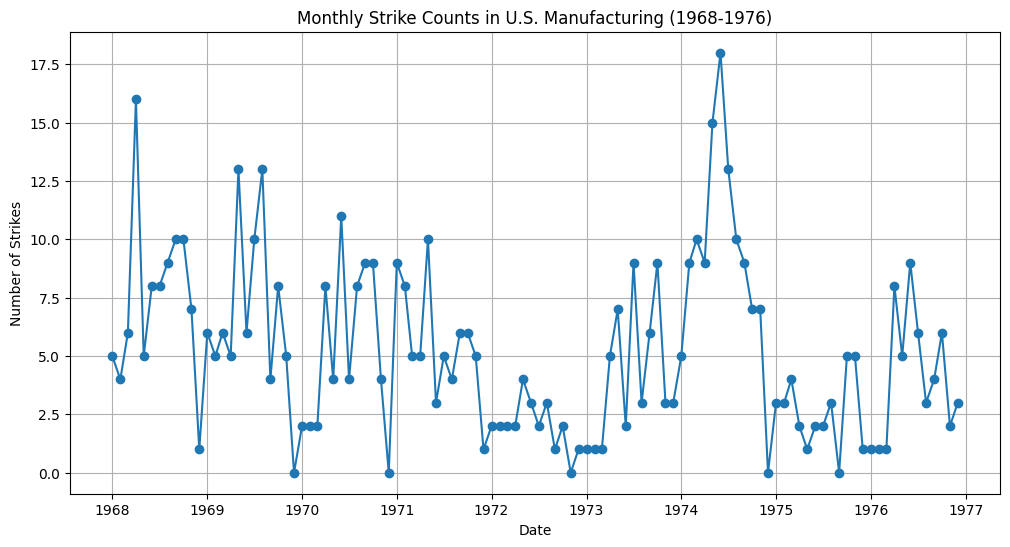

In [4]:
# Plot the time series of strikes
plt.figure(figsize=(12, 6))
plt.plot(strikes_data['date'], strikes_data['strikes'], marker='o', linestyle='-')
plt.title('Monthly Strike Counts in U.S. Manufacturing (1968-1976)')
plt.xlabel('Date')
plt.ylabel('Number of Strikes')
plt.grid(True)
plt.show()

# Explore the Data

In [5]:
# Display summary statistics
print("=== Summary Statistics ===")
display(strikes_data['strikes'].describe())

=== Summary Statistics ===


,strikes
count,108.000000
mean,5.240741
std,3.751312
min,0.000000
25%,2.000000
50%,5.000000
75%,8.000000
max,18.000000


In [6]:
# Check for overdispersion (Variance > Mean)
mean_strikes = strikes_data['strikes'].mean()
variance_strikes = strikes_data['strikes'].var()
print(f"Mean of Strikes: {mean_strikes:.2f}")
print(f"Variance of Strikes: {variance_strikes:.2f}")

if variance_strikes > mean_strikes:
    print("The data is overdispersed (Variance > Mean).")
else:
    print("The data is not overdispersed (Variance <= Mean).")

Mean of Strikes: 5.24
Variance of Strikes: 14.07
The data is overdispersed (Variance > Mean).


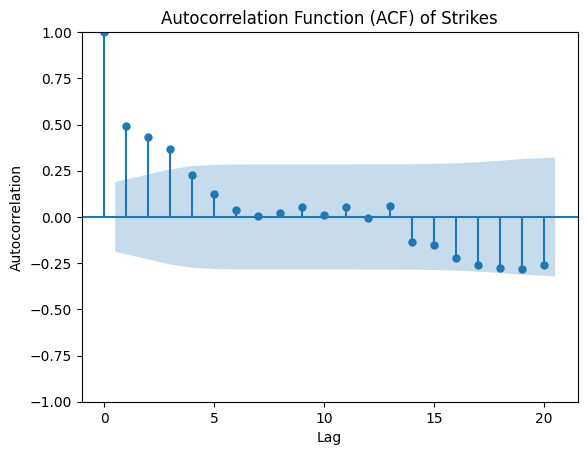

In [7]:
# Check autocorrelation using ACF plot
tsa.plot_acf(strikes_data['strikes'], lags=20, alpha=0.05)
plt.title('Autocorrelation Function (ACF) of Strikes')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

# Preprocess the Data

In [8]:
# Define the split ratio (80% training, 20% testing)
split_ratio = 0.8
split_point = int(len(strikes_data) * split_ratio)

strikes_data_train = strikes_data.iloc[:split_point].copy()
strikes_data_test = strikes_data.iloc[split_point:].copy()

print(f"Training Set Size: {len(strikes_data_train)}")
print(f"Testing Set Size: {len(strikes_data_test)}")

Training Set Size: 86
Testing Set Size: 22


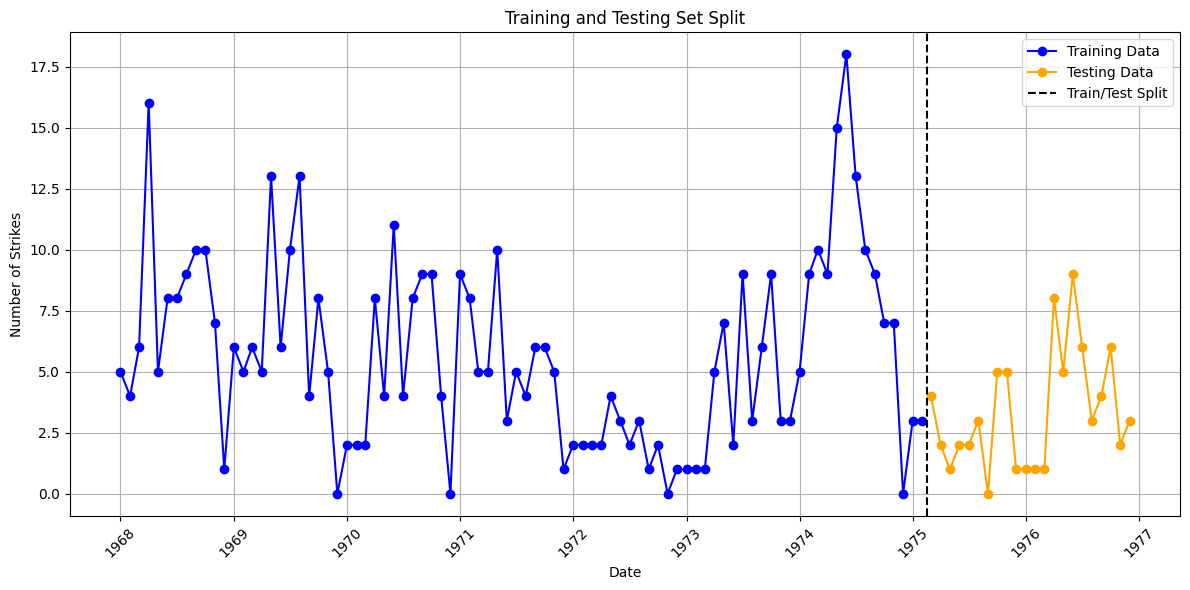

In [9]:
# Get the last train date and first test date
train_last_date = strikes_data_train['date'].iloc[-1]
test_first_date = strikes_data_test['date'].iloc[0]

# Calculate the average or midpoint between the two dates for an offset
split_line_position = train_last_date + (test_first_date - train_last_date) / 2

# Plot the train/test splits
plt.figure(figsize=(12, 6))
plt.plot(strikes_data_train['date'], strikes_data_train['strikes'], marker='o', linestyle='-', color='blue', label='Training Data')
plt.plot(strikes_data_test['date'], strikes_data_test['strikes'], marker='o', linestyle='-', color='orange', label='Testing Data')
plt.axvline(x=split_line_position, color='k', linestyle='--', label='Train/Test Split')
plt.title('Training and Testing Set Split')
plt.xlabel('Date')
plt.ylabel('Number of Strikes')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [10]:
# Define the number of lagged variables (N)
N = 3

# Function to create lagged variables
def create_lagged_features(df, target, lags):
    for lag in range(1, lags + 1):
        df[f'{target}_lag_{lag}'] = df[target].shift(lag)
    return df

In [11]:
# Function to create 'percent_change' variable
def create_percent_change(df, target):
    df[f'{target}_percent_change'] = df[target].pct_change() * 100
    # Handle inf and -inf values by replacing them with 0
    df[f'{target}_percent_change'].replace([np.inf, -np.inf], 0, inplace=True)
    return df

In [12]:
# Apply percent change
strikes_data_train = create_percent_change(strikes_data_train, 'strikes')
strikes_data_test = create_percent_change(strikes_data_test, 'strikes')

# Fill any remaining NaN values in 'percent_change' with 0
strikes_data_train['strikes_percent_change'] = strikes_data_train['strikes_percent_change'].fillna(0)
strikes_data_test['strikes_percent_change'] = strikes_data_test['strikes_percent_change'].fillna(0)

In [13]:
# Create lagged variables for training data
strikes_data_train = create_lagged_features(strikes_data_train, 'strikes', N)
strikes_data_train = strikes_data_train.dropna().reset_index(drop=True)  # Remove NaN caused by shifting

# Create lagged variables for testing data
for lag in range(1, N + 1):
    strikes_data_test[f'strikes_lag_{lag}'] = strikes_data_test['strikes'].shift(lag)

# Set the first N lags in the test set using the last N strikes from the training set
for lag in range(1, N + 1):
    strikes_data_test.loc[lag - 1, f'strikes_lag_{lag}'] = strikes_data_train['strikes'].iloc[-lag]

strikes_data_test = strikes_data_test.dropna().reset_index(drop=True)

# After filling lags, ensure no remaining NaNs or infs in percent_change
strikes_data_test['strikes_percent_change'] = strikes_data_test['strikes_percent_change'].fillna(0)
strikes_data_test['strikes_percent_change'].replace([np.inf, -np.inf], 0, inplace=True)

In [14]:
# Verify that lagged variables are created
print("=== Training Data Columns After Lagging ===")
print(strikes_data_train.columns)

print("\n=== Testing Data Columns After Lagging ===")
print(strikes_data_test.columns)

=== Training Data Columns After Lagging ===
Index(['strikes', 'output', 'time', 'date', 'strikes_percent_change',
       'strikes_lag_1', 'strikes_lag_2', 'strikes_lag_3'],
      dtype='object')

=== Testing Data Columns After Lagging ===
Index(['strikes', 'output', 'time', 'date', 'strikes_percent_change',
       'strikes_lag_1', 'strikes_lag_2', 'strikes_lag_3'],
      dtype='object')


In [15]:
# Define a threshold to identify spikes
spike_threshold = strikes_data_train['strikes'].quantile(0.95)

# Create spike indicators
strikes_data_train['spike'] = (strikes_data_train['strikes'] > spike_threshold).astype(int)
strikes_data_test['spike'] = (strikes_data_test['strikes'] > spike_threshold).astype(int)

In [16]:
def generate_fourier_terms(data, period, K):
    """
    Generate Fourier terms for seasonality.

    Parameters:
    - data: Pandas DataFrame with a datetime index or a 'date' column.
    - period: The number of observations that make up a complete seasonal cycle (e.g., 12 for monthly data with yearly seasonality).
    - K: Number of harmonics.

    Returns:
    - DataFrame containing sine and cosine terms.
    """
    t = np.arange(len(data))
    fourier_terms = {}
    for k in range(1, K + 1):
        fourier_terms[f'sin_{k}'] = np.sin(2 * np.pi * k * t / period)
        fourier_terms[f'cos_{k}'] = np.cos(2 * np.pi * k * t / period)
    return pd.DataFrame(fourier_terms, index=data.index)

In [17]:
# Define period and number of harmonics
period = 12  # For monthly data with yearly seasonality
K = 1        # Number of harmonics

# Generate Fourier terms
fourier_train = generate_fourier_terms(strikes_data_train, period=period, K=K)
fourier_test = generate_fourier_terms(strikes_data_test, period=period, K=K)

# Concatenate Fourier terms with the original data
strikes_data_train = pd.concat([strikes_data_train, fourier_train], axis=1)
strikes_data_test = pd.concat([strikes_data_test, fourier_test], axis=1)

In [18]:
# Function to check for missing or infinite values
def validate_data(df, dataset_name):
    if df.isnull().values.any():
        print(f"Warning: {dataset_name} contains NaN values.")

    # Only apply np.isinf() to numeric columns
    numeric_df = df.select_dtypes(include=[np.number])
    if np.isinf(numeric_df.values).any():
        print(f"Warning: {dataset_name} contains infinite values.")

    if not df.isnull().values.any() and not np.isinf(numeric_df.values).any():
        print(f"{dataset_name} is clean.")

# Validate training data
validate_data(strikes_data_train, "Training Data")
display(strikes_data_train.head())
print("\n")

# Validate testing data
validate_data(strikes_data_test, "Testing Data")
display(strikes_data_test.head())

Training Data is clean.


,strikes,output,time,date,strikes_percent_change,strikes_lag_1,strikes_lag_2,strikes_lag_3,spike,sin_1,cos_1
0,16,0.00473,4,1968-04-01,166.666667,6.0,4.0,5.0,1,0.000000,1.000000e+00
1,5,0.01277,5,1968-05-01,-68.750000,16.0,6.0,4.0,0,0.500000,8.660254e-01
2,8,0.01138,6,1968-06-01,60.000000,5.0,16.0,6.0,0,0.866025,5.000000e-01
3,8,0.00424,7,1968-07-01,0.000000,8.0,5.0,16.0,0,1.000000,6.123234e-17
4,9,-0.00687,8,1968-08-01,12.500000,8.0,8.0,5.0,0,0.866025,-5.000000e-01




Testing Data is clean.


,strikes,output,time,date,strikes_percent_change,strikes_lag_1,strikes_lag_2,strikes_lag_3,spike,sin_1,cos_1
0,2.0,-0.10443,90.0,1975-06-01,100.0,1.0,2.0,4.0,0,0.000000,1.000000e+00
1,2.0,-0.08656,91.0,1975-07-01,0.0,2.0,1.0,2.0,0,0.500000,8.660254e-01
2,3.0,-0.06279,92.0,1975-08-01,50.0,2.0,2.0,1.0,0,0.866025,5.000000e-01
3,0.0,-0.06034,93.0,1975-09-01,-100.0,3.0,2.0,2.0,0,1.000000,6.123234e-17
4,5.0,-0.05790,94.0,1975-10-01,0.0,0.0,3.0,2.0,0,0.866025,-5.000000e-01


# Fit the Models

## Poisson Regression

In [19]:
# Define the regression formula
fourier_terms = '+'.join([f'sin_{k} + cos_{k}' for k in range(1, K + 1)])
expr_poisson = f'strikes ~ output + strikes_lag_1 + strikes_lag_2 + strikes_lag_3 + strikes_percent_change + spike + {fourier_terms}'

# Create design matrices using Patsy
y_train_poisson, X_train_poisson = dmatrices(expr_poisson, strikes_data_train, return_type='dataframe')
y_test_poisson, X_test_poisson = dmatrices(expr_poisson, strikes_data_test, return_type='dataframe')

# Fit the Poisson Regression Model
poisson_model = dm.Poisson(endog=y_train_poisson, exog=X_train_poisson)
poisson_results = poisson_model.fit(maxiter=100, disp=False)
print(poisson_results.summary())
print("\n")
print(poisson_results.summary2())

                          Poisson Regression Results                          
Dep. Variable:                strikes   No. Observations:                   83
Model:                        Poisson   Df Residuals:                       74
Method:                           MLE   Df Model:                            8
Date:                Sat, 23 Nov 2024   Pseudo R-squ.:                  0.2729
Time:                        09:33:07   Log-Likelihood:                -184.86
converged:                       True   LL-Null:                       -254.26
Covariance Type:            nonrobust   LLR p-value:                 4.218e-26
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  0.8295      0.130      6.366      0.000       0.574       1.085
output                    -1.5294      1.027     -1.489      0.137      -3.543       0.484
stri

## Negative Binomial Regression

In [20]:
# Define the regression formula
fourier_terms = '+'.join([f'sin_{k} + cos_{k}' for k in range(1, K + 1)])
expr_nb = f'strikes ~ output + strikes_lag_1 + strikes_lag_2 + strikes_lag_3 + strikes_percent_change + spike + {fourier_terms}'

# Create design matrices using Patsy
y_train_nb, X_train_nb = dmatrices(expr_nb, strikes_data_train, return_type='dataframe')
y_test_nb, X_test_nb = dmatrices(expr_nb, strikes_data_test, return_type='dataframe')

# Fit the Negative Binomial Regression Model (NB2)
nb_model = dm.NegativeBinomial(endog=y_train_nb, exog=X_train_nb, loglike_method='nb2')
nb_results = nb_model.fit(maxiter=3000, method='ncg')
print(nb_results.summary())
print("\n")
print(nb_results.summary2())

Optimization terminated successfully.
         Current function value: 2.226922
         Iterations: 8
         Function evaluations: 10
         Gradient evaluations: 10
         Hessian evaluations: 8
                     NegativeBinomial Regression Results                      
Dep. Variable:                strikes   No. Observations:                   83
Model:               NegativeBinomial   Df Residuals:                       74
Method:                           MLE   Df Model:                            8
Date:                Sat, 23 Nov 2024   Pseudo R-squ.:                  0.1756
Time:                        09:33:07   Log-Likelihood:                -184.83
converged:                       True   LL-Null:                       -224.21
Covariance Type:            nonrobust   LLR p-value:                 8.754e-14
                             coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------

## Poisson INAR Model

In [21]:
# Top-level function for cached binomial PMF
@lru_cache(maxsize=None)
def binom_pmf_cached(j, y_prev, rho_i):
    """
    Cached binomial PMF to speed up computations.

    Parameters:
    - j: Number of successes.
    - y_prev: Number of trials.
    - rho_i: Probability of success.

    Returns:
    - Binomial PMF value.
    """
    return binom.pmf(j, y_prev, rho_i)

# Top-level function to compute total log probability for PoissonINAR
def compute_total_log_prob_pois(y_t, y_lags, rho, mu_t, max_j=5):
    """
    Compute the log probability for a single observation in Poisson INAR.

    Parameters:
    - y_t: Observed count at time t.
    - y_lags: Array of lagged counts.
    - rho: Array of thinning parameters.
    - mu_t: Exponential of linear predictor at time t.
    - max_j: Maximum threshold to consider.

    Returns:
    - Log probability for observation t.
    """
    prob_y_t = 0.0
    j_ranges = [range(0, min(int(y_prev) + 1, max_j + 1)) for y_prev in y_lags]
    for j_tuple in product(*j_ranges):
        j_total = sum(j_tuple)
        if j_total > y_t:
            continue  # Invalid combination, skip

        p_combination = 1.0
        for i in range(len(j_tuple)):
            j_i = j_tuple[i]
            y_prev = y_lags[i]
            p_j_i = binom_pmf_cached(j_i, int(y_prev), rho[i])
            p_combination *= p_j_i

        p_k = poisson.pmf(y_t - j_total, mu_t)
        prob_y_t += p_combination * p_k

    prob_y_t = max(prob_y_t, 1e-10)  # Prevent log(0)
    return math.log(prob_y_t)

In [22]:
class PoissonINAR(GenericLikelihoodModel):
    def __init__(self, endog, exog, p=1, n_jobs=-1, **kwds):
        """
        Initialize the Poisson INAR model.

        Parameters:
        - endog: The dependent variable (array-like).
        - exog: The exogenous variables (array-like), excluding the lagged y's.
        - p: Number of lags (integer).
        - n_jobs: Number of parallel jobs (integer). Default -1 uses all available cores.
        """
        self.p = p  # Number of lags
        self.n_jobs = n_jobs  # Number of parallel jobs
        super(PoissonINAR, self).__init__(endog, exog, **kwds)

    def nloglikeobs(self, params):
        """
        Compute the negative log-likelihood for each observation.

        Parameters:
        - params: The parameter vector [beta coefficients..., gamma1, gamma2, ..., gamma_p].

        Returns:
        - Array of negative log-likelihood values for each observation.
        """
        num_beta = self.exog.shape[1]
        beta = params[:num_beta]
        gamma = params[num_beta:]

        rho = 1.0 / (1.0 + np.exp(-gamma))  # rho = [rho1, rho2, ..., rho_p]
        mu = np.exp(np.dot(self.exog, beta))  # Linear predictor

        # Prepare the arguments for parallel processing
        obs_args = [
            (self.endog[t], self.endog[t - self.p:t], tuple(rho), mu[t])
            for t in range(self.p, len(self.endog))
        ]

        # Compute log probabilities in parallel using the 'threading' backend
        log_probs = Parallel(n_jobs=self.n_jobs, backend='threading')(
            delayed(compute_total_log_prob_pois)(y_t, y_lags, rho, mu_t)
            for y_t, y_lags, rho, mu_t in obs_args
        )

        return -np.array(log_probs)

    def fit(self, start_params=None, maxiter=1000, maxfun=5000, **kwds):
        """
        Fit the Poisson INAR model.

        Parameters:
        - start_params: Initial guess for the parameters.
        - maxiter: Maximum number of iterations.
        - maxfun: Maximum number of function evaluations.

        Returns:
        - Fitted model results.
        """
        num_beta = self.exog.shape[1]
        num_rho = self.p

        if start_params is None:
            start_beta = np.zeros(num_beta)
            start_gamma = np.zeros(num_rho)
            start_params = np.concatenate([start_beta, start_gamma])

        return super(PoissonINAR, self).fit(
            start_params=start_params,
            maxiter=maxiter,
            maxfun=maxfun,
            **kwds
        )

    def predict_custom(self, params, exog=None, last_p_y=None):
        """
        Predict using the fitted Poisson INAR model.

        Parameters:
        - params: The fitted parameter vector [beta coefficients..., gamma1, gamma2, ..., gamma_p].
        - exog: Exogenous variables for prediction (array-like).
        - last_p_y: List of the last p y's from the training data to initialize predictions.

        Returns:
        - Array of predicted y values.
        """
        num_beta = self.exog.shape[1]
        beta = params[:num_beta]
        gamma = params[num_beta:]

        # Compute thinning parameters
        rho = 1.0 / (1.0 + np.exp(-gamma))  # rho = [rho1, rho2, ..., rho_p]

        # Compute mean of Poisson innovation term
        mu = np.exp(np.dot(exog, beta))  # Linear predictor

        # Ensure last_p_y is provided
        if last_p_y is None:
            raise ValueError("last_p_y (last p y's from training data) must be provided for prediction.")

        last_p_y = list(last_p_y)  # Mutable copy of last p y values

        # Initialize list to store predictions
        y_pred = []

        for i in range(len(exog)):
            y_lags = last_p_y.copy()  # Get the lagged values
            mu_t = mu[i]  # Innovation term

            # Stochastic thinning process for each lag
            carried_over = 0
            for j in range(self.p):
                carried_over += np.random.binomial(y_lags[j], rho[j])

            # Add the innovation component
            y_t_pred = carried_over + np.random.poisson(mu_t)
            y_pred.append(y_t_pred)

            # Update the lagged values
            last_p_y.pop(0)
            last_p_y.append(y_t_pred)

        return np.array(y_pred)

In [23]:
# Define the regression formula (excluding lagged y's)
fourier_terms = '+'.join([f'sin_{k} + cos_{k}' for k in range(1, K + 1)])
expr_poinar = f'strikes ~ output + strikes_percent_change + spike + {fourier_terms}'

# Create design matrices using Patsy
y_train_poinar, X_train_poinar = dmatrices(expr_poinar, strikes_data_train, return_type='dataframe')
y_test_poinar, X_test_poinar = dmatrices(expr_poinar, strikes_data_test, return_type='dataframe')

# Identify variables
main_vars = ['output', 'strikes_percent_change', 'spike']
fourier_vars = [col for col in X_train_poinar.columns if col.startswith('sin_') or col.startswith('cos_')]
exog_vars = main_vars + fourier_vars

# Initialize the Poisson INAR model
poinar_model = PoissonINAR(
    endog=y_train_poinar['strikes'].values,
    exog=X_train_poinar[exog_vars].values,
    p=N  # Specify the number of AR terms
)

# Fit the Poisson INAR model
poinar_results = poinar_model.fit()
print(poinar_results.summary())

                             PoissonINAR Results                              
Dep. Variable:                      y   Log-Likelihood:                -193.54
Model:                    PoissonINAR   AIC:                             401.1
Method:            Maximum Likelihood   BIC:                             418.0
Date:                Sat, 23 Nov 2024                                         
Time:                        09:59:14                                         
No. Observations:                  83                                         
Df Residuals:                      78                                         
Df Model:                           4                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.3975      2.786      0.502      0.616      -4.063       6.858
x2             0.0029      0.001      3.511      0.0

# Information Criteria

In [24]:
# Initialize a list to hold evaluation metrics for each model
evaluation_metrics = []

# Compute AIC and BIC and append metrics to list for each model
evaluation_metrics.append({
    'Model': 'Poisson',
    'AIC': poisson_results.aic,
    'BIC': poisson_results.bic
})

evaluation_metrics.append({
    'Model': 'NegativeBinomial',
    'AIC': nb_results.aic,
    'BIC': nb_results.bic
})

evaluation_metrics.append({
    'Model': 'Poisson_INAR',
    'AIC': poinar_results.aic,
    'BIC': poinar_results.bic
})

# Create DataFrame from the list of dictionaries
evaluation_metrics_df = pd.DataFrame(evaluation_metrics)

# Display the DataFrame
display(evaluation_metrics_df)

,Model,AIC,BIC
0,Poisson,387.726238,409.495803
1,NegativeBinomial,389.669061,413.857467
2,Poisson_INAR,401.073915,418.005800


# Model Predictions

In [25]:
# Initialize a DataFrame to store predictions
predictions_df = pd.DataFrame(index=strikes_data_test.index)
predictions_df['Time'] = strikes_data_test['date'].values
predictions_df['Actual'] = strikes_data_test['strikes'].values

In [26]:
# Predictions from Poisson regression
poisson_pred = poisson_results.predict(X_test_poisson)
poisson_pred_rounded = np.round(poisson_pred).astype(int)
predictions_df['Poisson'] = poisson_pred_rounded.values.astype('float').round()

In [27]:
# Predictions from Negative Binomial regression
nb_pred = nb_results.predict(X_test_nb)
nb_pred_rounded = np.round(nb_pred).astype(int)
predictions_df['NegativeBinomial'] = nb_pred_rounded.values.astype('float').round()

In [28]:
# For Poisson INAR
last_p_y_poinar = strikes_data_train['strikes'].iloc[-N:].values

In [29]:
# Generate predictions using the Poisson INAR Model
poinar_predictions = poinar_model.predict_custom(
    params=poinar_results.params,
    exog=X_test_poinar[exog_vars].values,
    last_p_y=last_p_y_poinar
)

# Add predictions to the DataFrame
predictions_df['Poisson_INAR'] = poinar_predictions.round()

In [30]:
# Display the predictions DataFrame
display(predictions_df)

,Time,Actual,Poisson,NegativeBinomial,Poisson_INAR
0,1975-06-01,2.0,5.0,5.0,4
1,1975-07-01,2.0,4.0,4.0,6
2,1975-08-01,3.0,4.0,4.0,5
3,1975-09-01,0.0,3.0,3.0,7
4,1975-10-01,5.0,3.0,3.0,6
5,1975-11-01,5.0,4.0,4.0,4
6,1975-12-01,1.0,3.0,3.0,5
7,1976-01-01,1.0,3.0,3.0,4
8,1976-02-01,1.0,2.0,2.0,1
9,1976-03-01,1.0,2.0,2.0,4


In [31]:
# Helper function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # To avoid division by zero
    non_zero = y_true != 0
    return np.mean(np.abs((y_true[non_zero] - y_pred[non_zero]) / y_true[non_zero])) * 100

In [32]:
# Helper function to calculate sMAPE
def symmetric_mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    non_zero = denominator != 0
    return np.mean(np.abs(y_true[non_zero] - y_pred[non_zero]) / denominator[non_zero]) * 100

In [33]:
# Initialize a dictionary to store metrics
metrics_dict = {
    'Model': [],
    'MSE': [],
    'RMSE': [],
    'MAE': [],
    'MAPE': [],
    'sMAPE': []
}

# Calculate metrics for each model
models = ['Poisson', 'NegativeBinomial', 'Poisson_INAR']
for model in models:
    y_pred = predictions_df[model]
    y_true = predictions_df['Actual']

    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    smape = symmetric_mean_absolute_percentage_error(y_true, y_pred)

    metrics_dict['Model'].append(model)
    metrics_dict['MSE'].append(mse)
    metrics_dict['RMSE'].append(rmse)
    metrics_dict['MAE'].append(mae)
    metrics_dict['MAPE'].append(mape)
    metrics_dict['sMAPE'].append(smape)

# Create a DataFrame
metrics_df = pd.DataFrame(metrics_dict)
display(metrics_df)

,Model,MSE,RMSE,MAE,MAPE,sMAPE
0,Poisson,13.578947,3.684962,2.315789,79.907407,60.288600
1,NegativeBinomial,13.578947,3.684962,2.315789,79.907407,60.288600
2,Poisson_INAR,8.157895,2.856203,2.368421,101.435185,65.429191


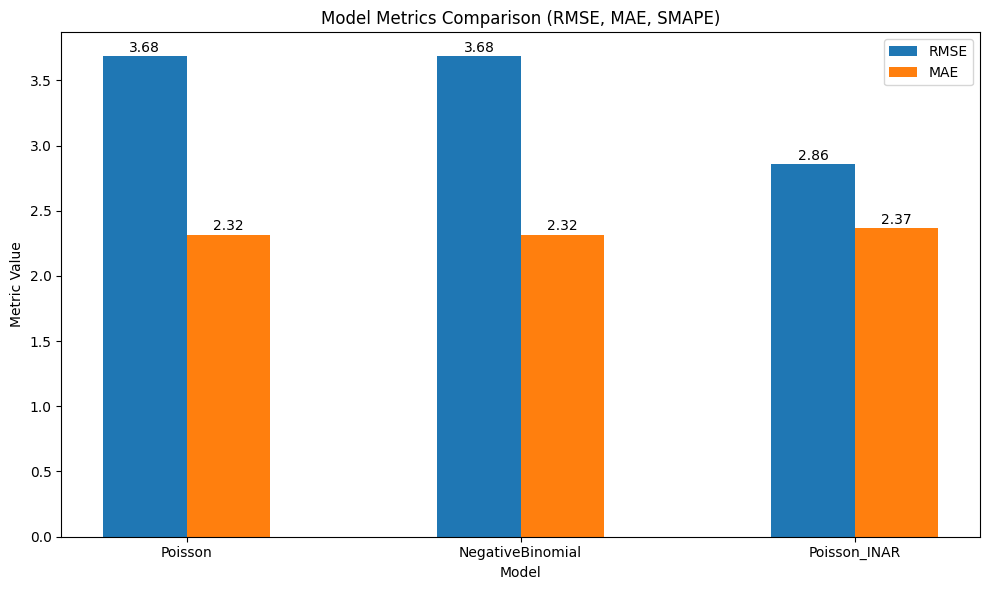

In [34]:
# Plot grouped bar chart
metrics_to_plot = ['RMSE', 'MAE']
x = np.arange(len(models))  # Label locations
width = 0.25  # Width of the bars

fig, ax = plt.subplots(figsize=(10, 6))
for i, metric in enumerate(metrics_to_plot):
    ax.bar(x + i * width, metrics_df[metric], width, label=metric)
    # Add metric value labels above the bars
    for j in range(len(models)):
        ax.text(x[j] + i * width, metrics_df[metric][j] + 0.01, f'{metrics_df[metric][j]:.2f}',
                ha='center', va='bottom', fontsize=10)

# Set axis labels and title
ax.set_xlabel('Model')
ax.set_ylabel('Metric Value')
ax.set_title('Model Metrics Comparison (RMSE, MAE, SMAPE)')
ax.set_xticks(x + (width * (len(metrics_to_plot) - 1)) / 2)
ax.set_xticklabels(models)
ax.legend()

plt.tight_layout()
plt.show()

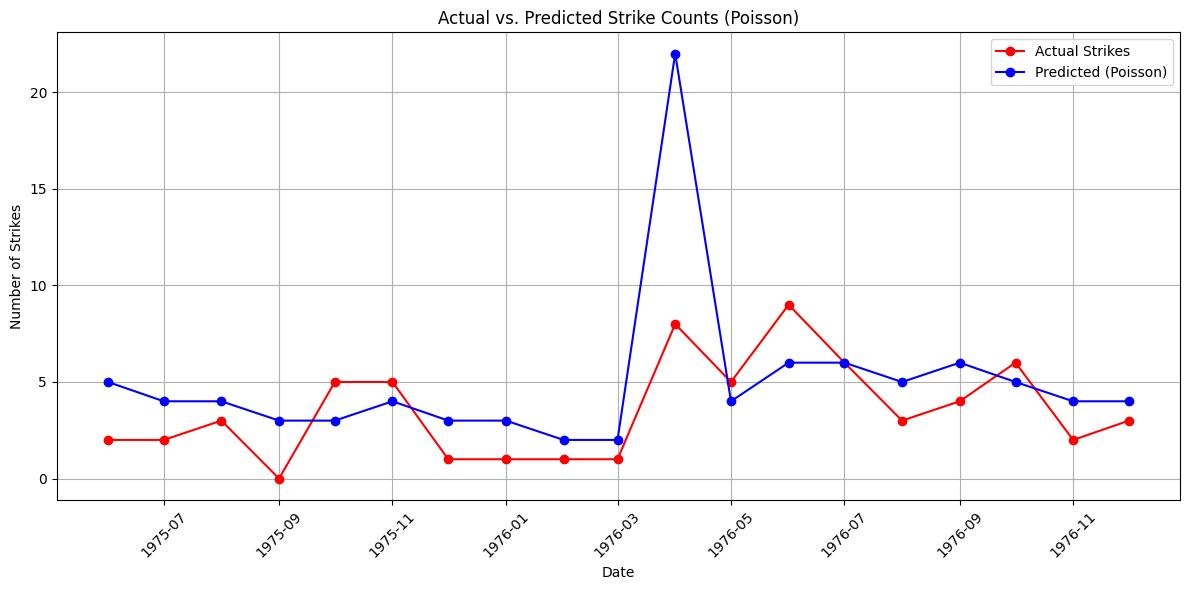

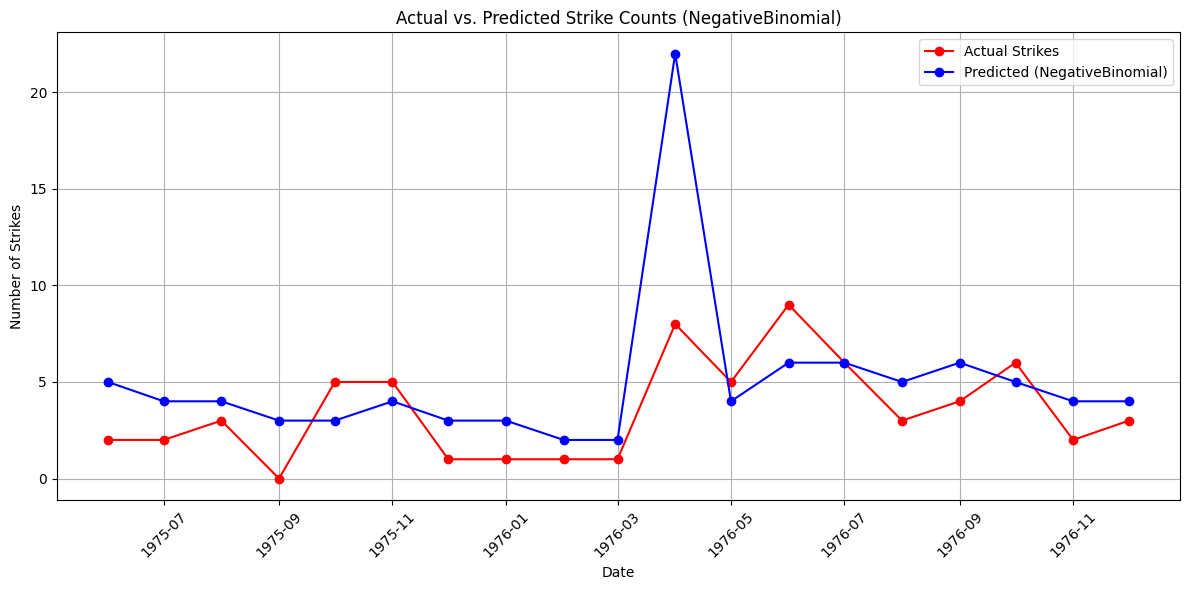

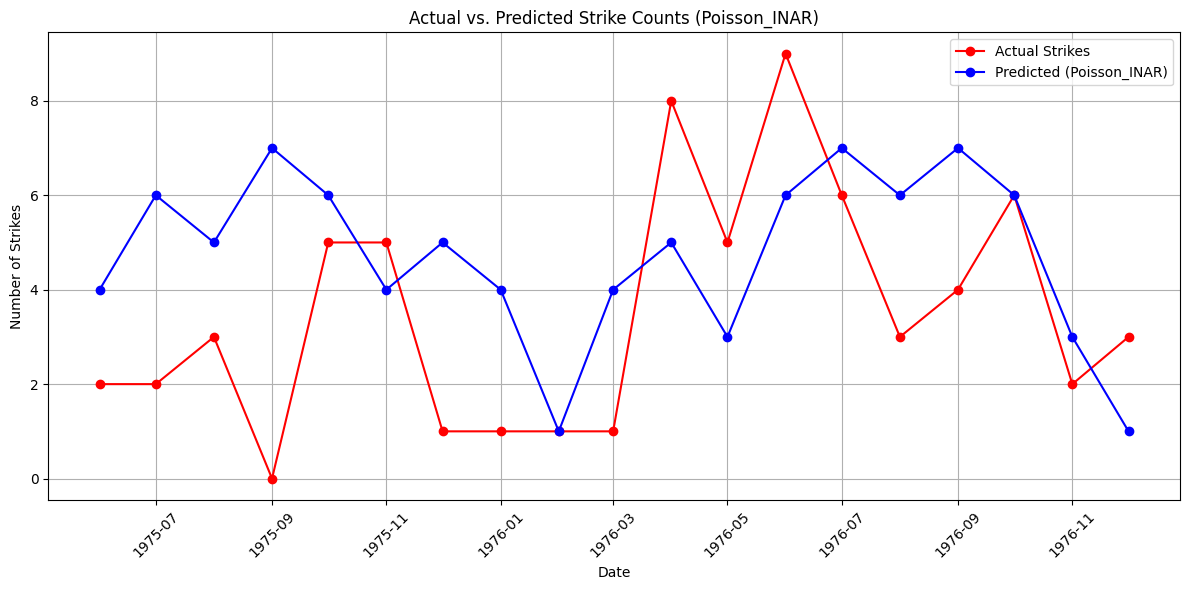

In [35]:
# Plot actual vs. predicted values
model_names = ['Poisson', 'NegativeBinomial', 'Poisson_INAR']
for model in model_names:
    plt.figure(figsize=(12, 6))
    plt.plot(predictions_df['Time'], predictions_df['Actual'], 'ro-', label='Actual Strikes')
    plt.plot(predictions_df['Time'], predictions_df[model], 'bo-', label=f'Predicted ({model})')
    plt.title(f'Actual vs. Predicted Strike Counts ({model})')
    plt.xlabel('Date')
    plt.ylabel('Number of Strikes')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    print("\n")